# Set Up

## Mount Google Drive

Ignore if not using Google Collab:

In [1]:
from google.colab import drive

# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/FranciscoLozCoding/cooling_with_code.git
%cd cooling_with_code
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
fatal: destination path 'cooling_with_code' already exists and is not an empty directory.
/content/drive/My Drive/cooling_with_code
Already up to date.


## Import Libraries

In [7]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#data science
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize

#custom tools
from tools.environment import VALID_SPLIT, RANDOM_STATE
from tools.feature_selection import load_and_prepare_data
from tools.outlier import univariate_outlier_analysis
from tools.distribution import plot_all_histograms

## Import Datasets

In [3]:
#load in datasets
raw = pd.read_csv('data/train/150m_buffer_dataset.csv')

# Helper Functions

In [9]:
def apply_winsorization(df, limits=(0.01, 0.01)):
    """
    Apply Winsorization to all numerical columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The dataset containing numerical features.
        limits (tuple): The lower and upper quantile limits for Winsorization.

    Returns:
        pd.DataFrame: The Winsorized dataset.
    """
    df_winsorized = df.copy()  # Create a copy to avoid modifying original data

    # Apply Winsorization to all numeric columns
    for col in df_winsorized.select_dtypes(include=['number']).columns:
        df_winsorized[col] = winsorize(df_winsorized[col], limits=limits)

    return df_winsorized

In [78]:
def apply_boxcox_transformation(df, threshold, exclude_cols=[]):
    """
    Apply Box-Cox transformation to specified DataFrame based on skew threshold.

    Parameters:
        df (pd.DataFrame): The dataset containing numerical features.
        threshold (float): The absolute value of the skew threshold.
        exclude_cols (list): List of column names to exclude from transformation.

    Returns:
        pd.DataFrame: The dataset with Box-Cox transformed columns.
    """
    df_transformed = df.copy()  # Create a copy to avoid modifying original data

    # get cols to apply transformation
    boxcox_cols = [col for col in df_transformed.columns if abs(skew(df_transformed[col])) > threshold]
    if exclude_cols:
        boxcox_cols = [col for col in boxcox_cols if col not in exclude_cols]

    for col in boxcox_cols:
        # Ensure all values are positive before applying Box-Cox
        if (df_transformed[col] <= 0).any():
            df_transformed[col] += abs(df_transformed[col].min()) + 1  # Shift to positive

        # Apply Box-Cox transformation
        df_transformed[col], _ = boxcox(df_transformed[col])

    return df_transformed

# Preprocessing

This notebook is for applying what we learned in [04_EDA](/04_EDA.ipynb) to our dataset. For details on the train/test dataset refer to our past notebooks:
- [01_dataset_generation](/01_dataset_generation.ipynb)
- [02_more_dataset_generation](/02_more_dataset_generation.ipynb)

Like stated in [04_EDA](/04_EDA.ipynb) we will only move forward with 150m Buffer dataset.

>NOTE: Most of the discovery was done in [04_EDA](/04_EDA.ipynb). This notebook will be more about applying the solutions.

In [71]:
#copy dataset, for editing
dataset = raw.copy()

## Eliminating Outliers

First, we will eliminate outliers. To do this we will use Winsorization. This preserves data size while reducing outlier influence by replacing outliers with the nearest valid value. First, lets plot the data before eliminating outliers.

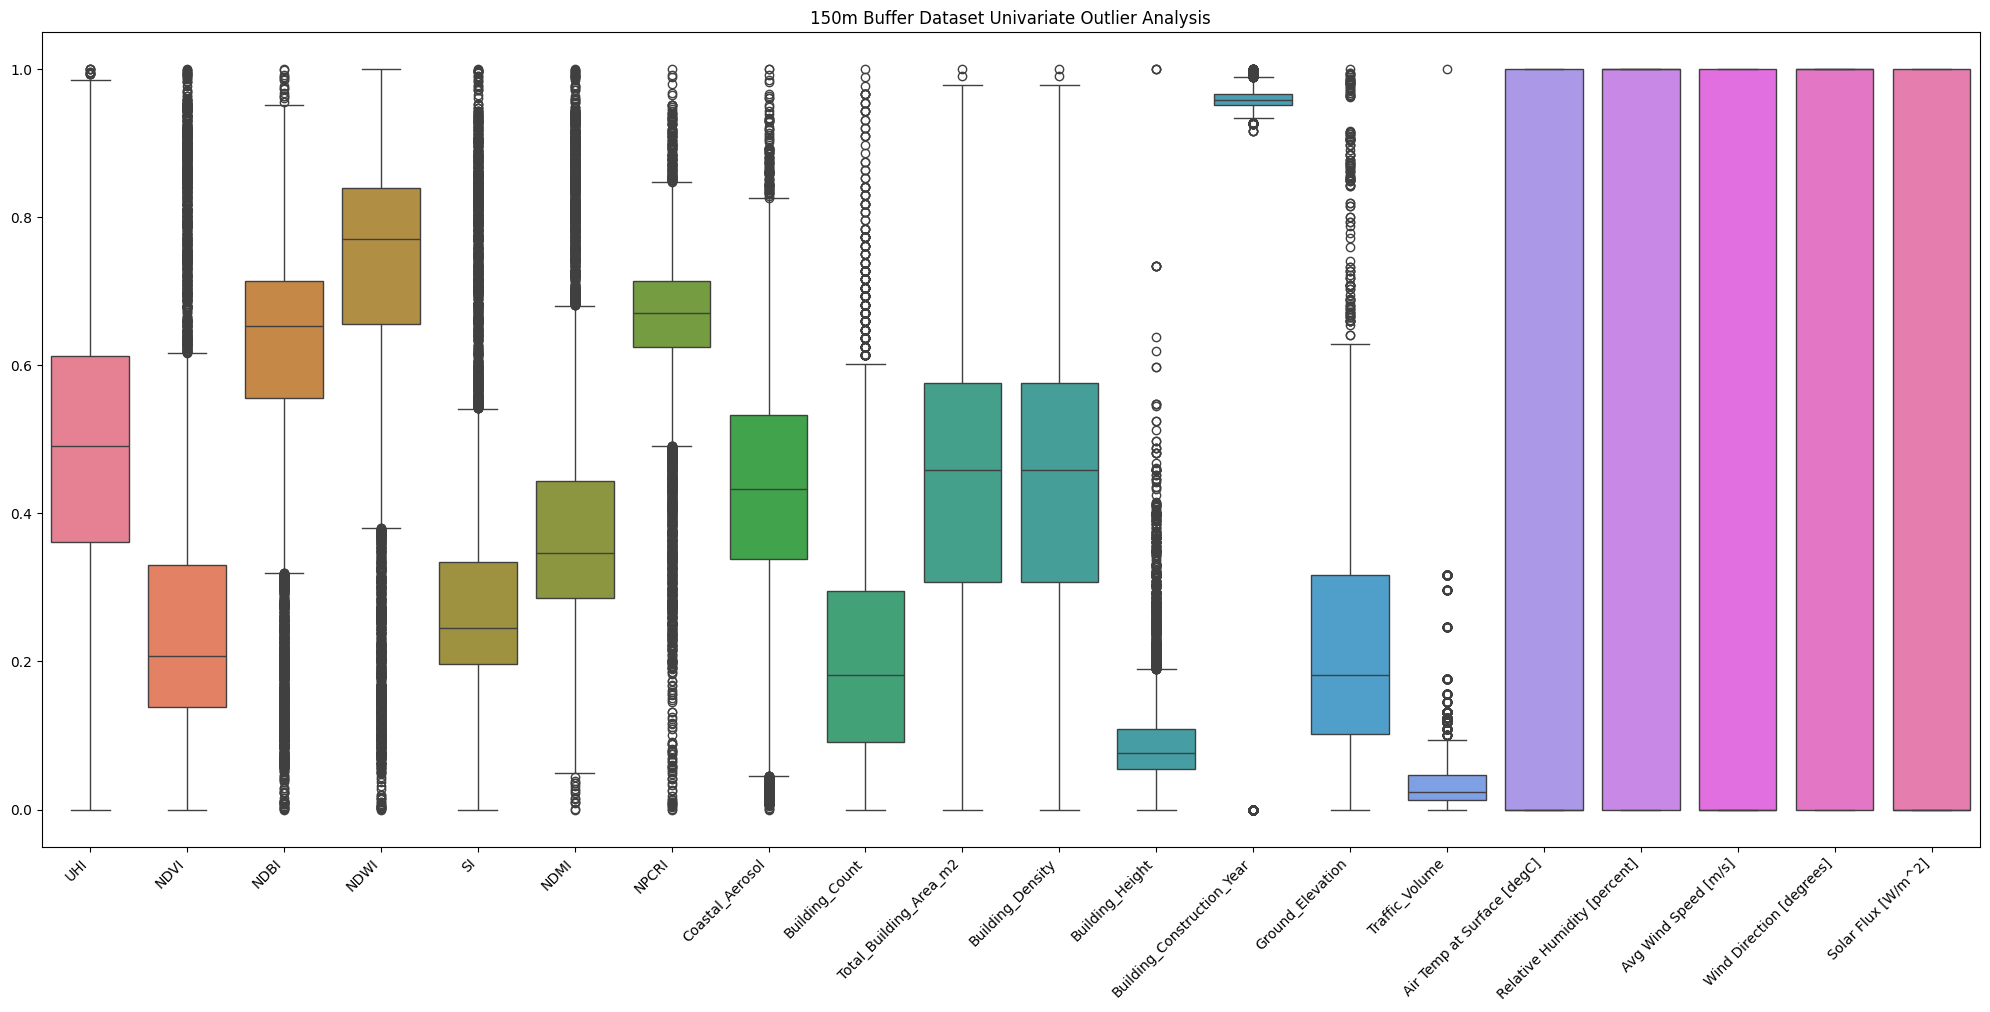

In [72]:
univariate_outlier_analysis(dataset, "150m Buffer Dataset")

Now, lets eliminate outliers

In [73]:
# we won't apply the transformation on target variable
uhi = dataset.pop('UHI')
dataset = apply_winsorization(dataset,(0.03, 0.03))  # Cap bottom/top 3%
dataset['UHI'] = uhi

Finally, we will plot the data again to see the effect.

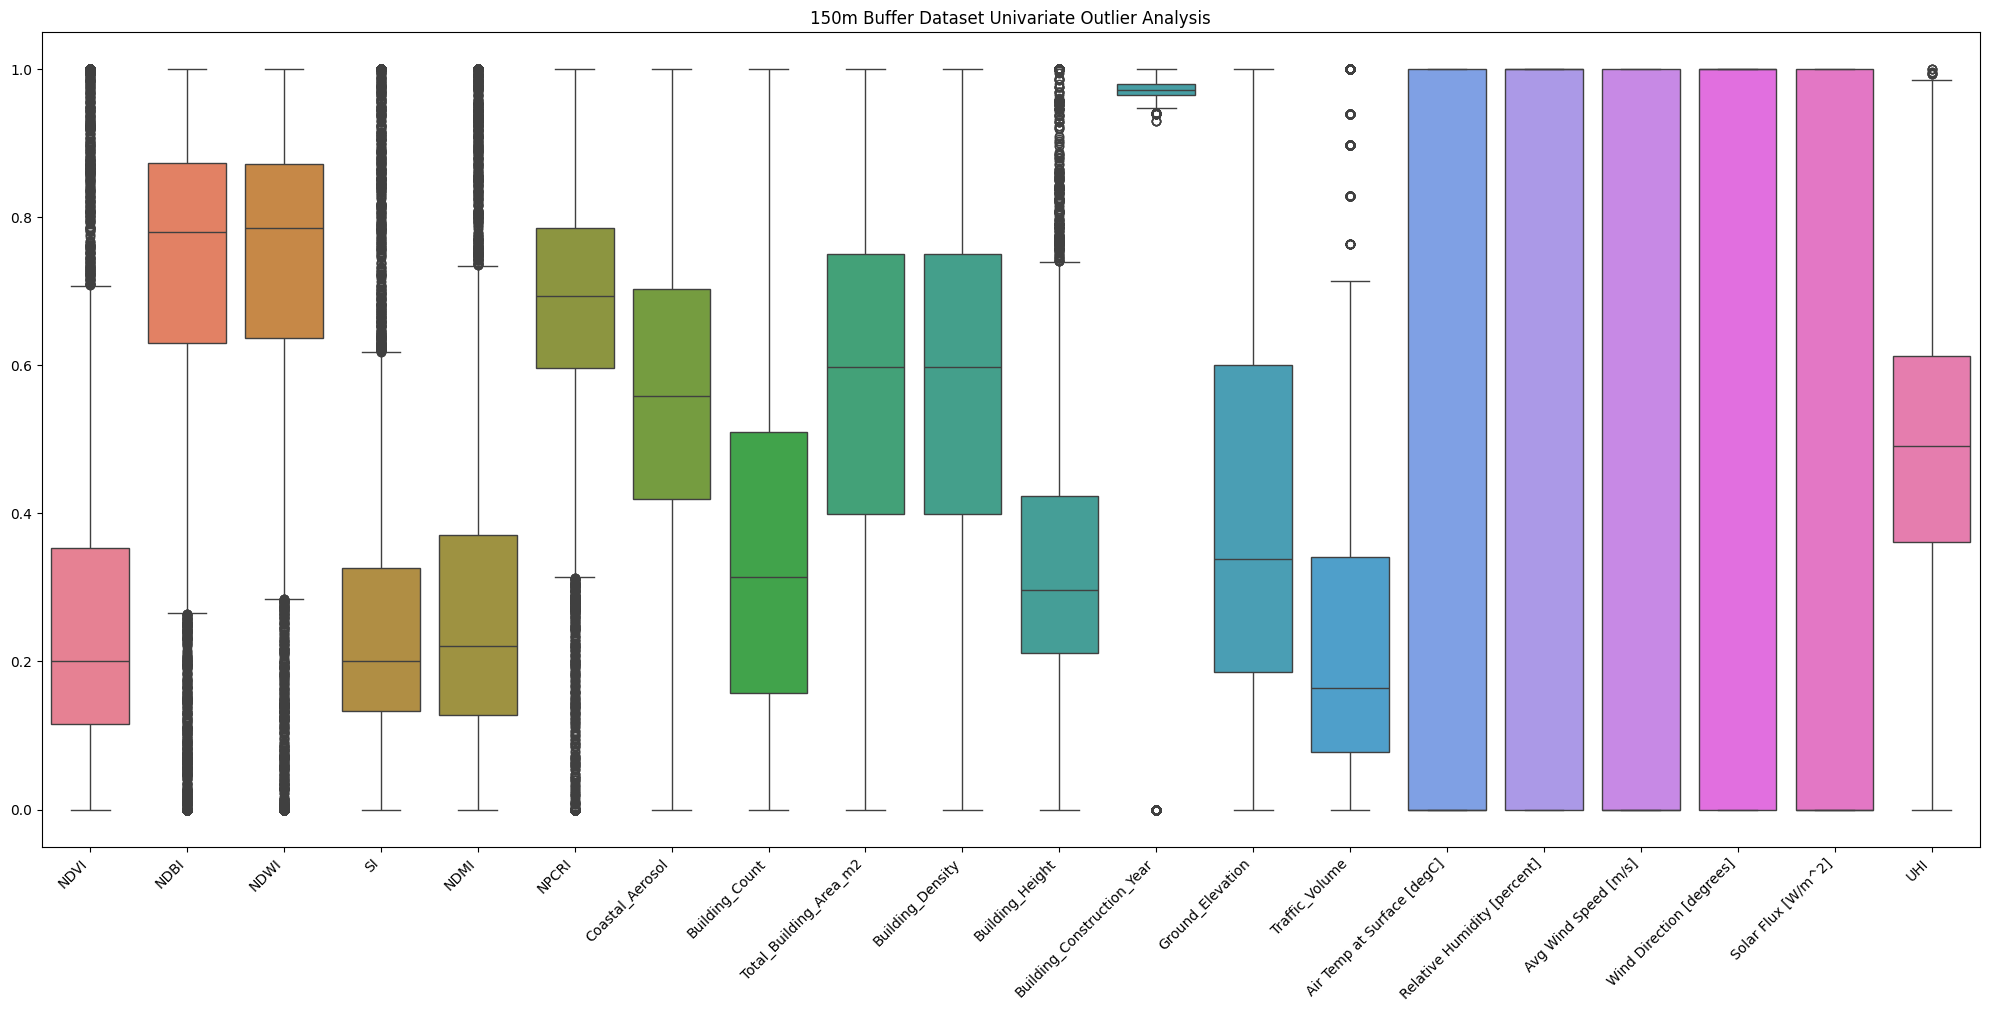

In [74]:
univariate_outlier_analysis(dataset, "150m Buffer Dataset")

We can see in the second graph that outliers in Coastal Aerosal, Building Count, Building Area, and Building Density were eliminated. All other features are skewed so we will now fix this.

## Eliminating Skewness

Here we will apply `boxcox` to the features that are skewed. To quantify skewness we will use `skew` from scipy.

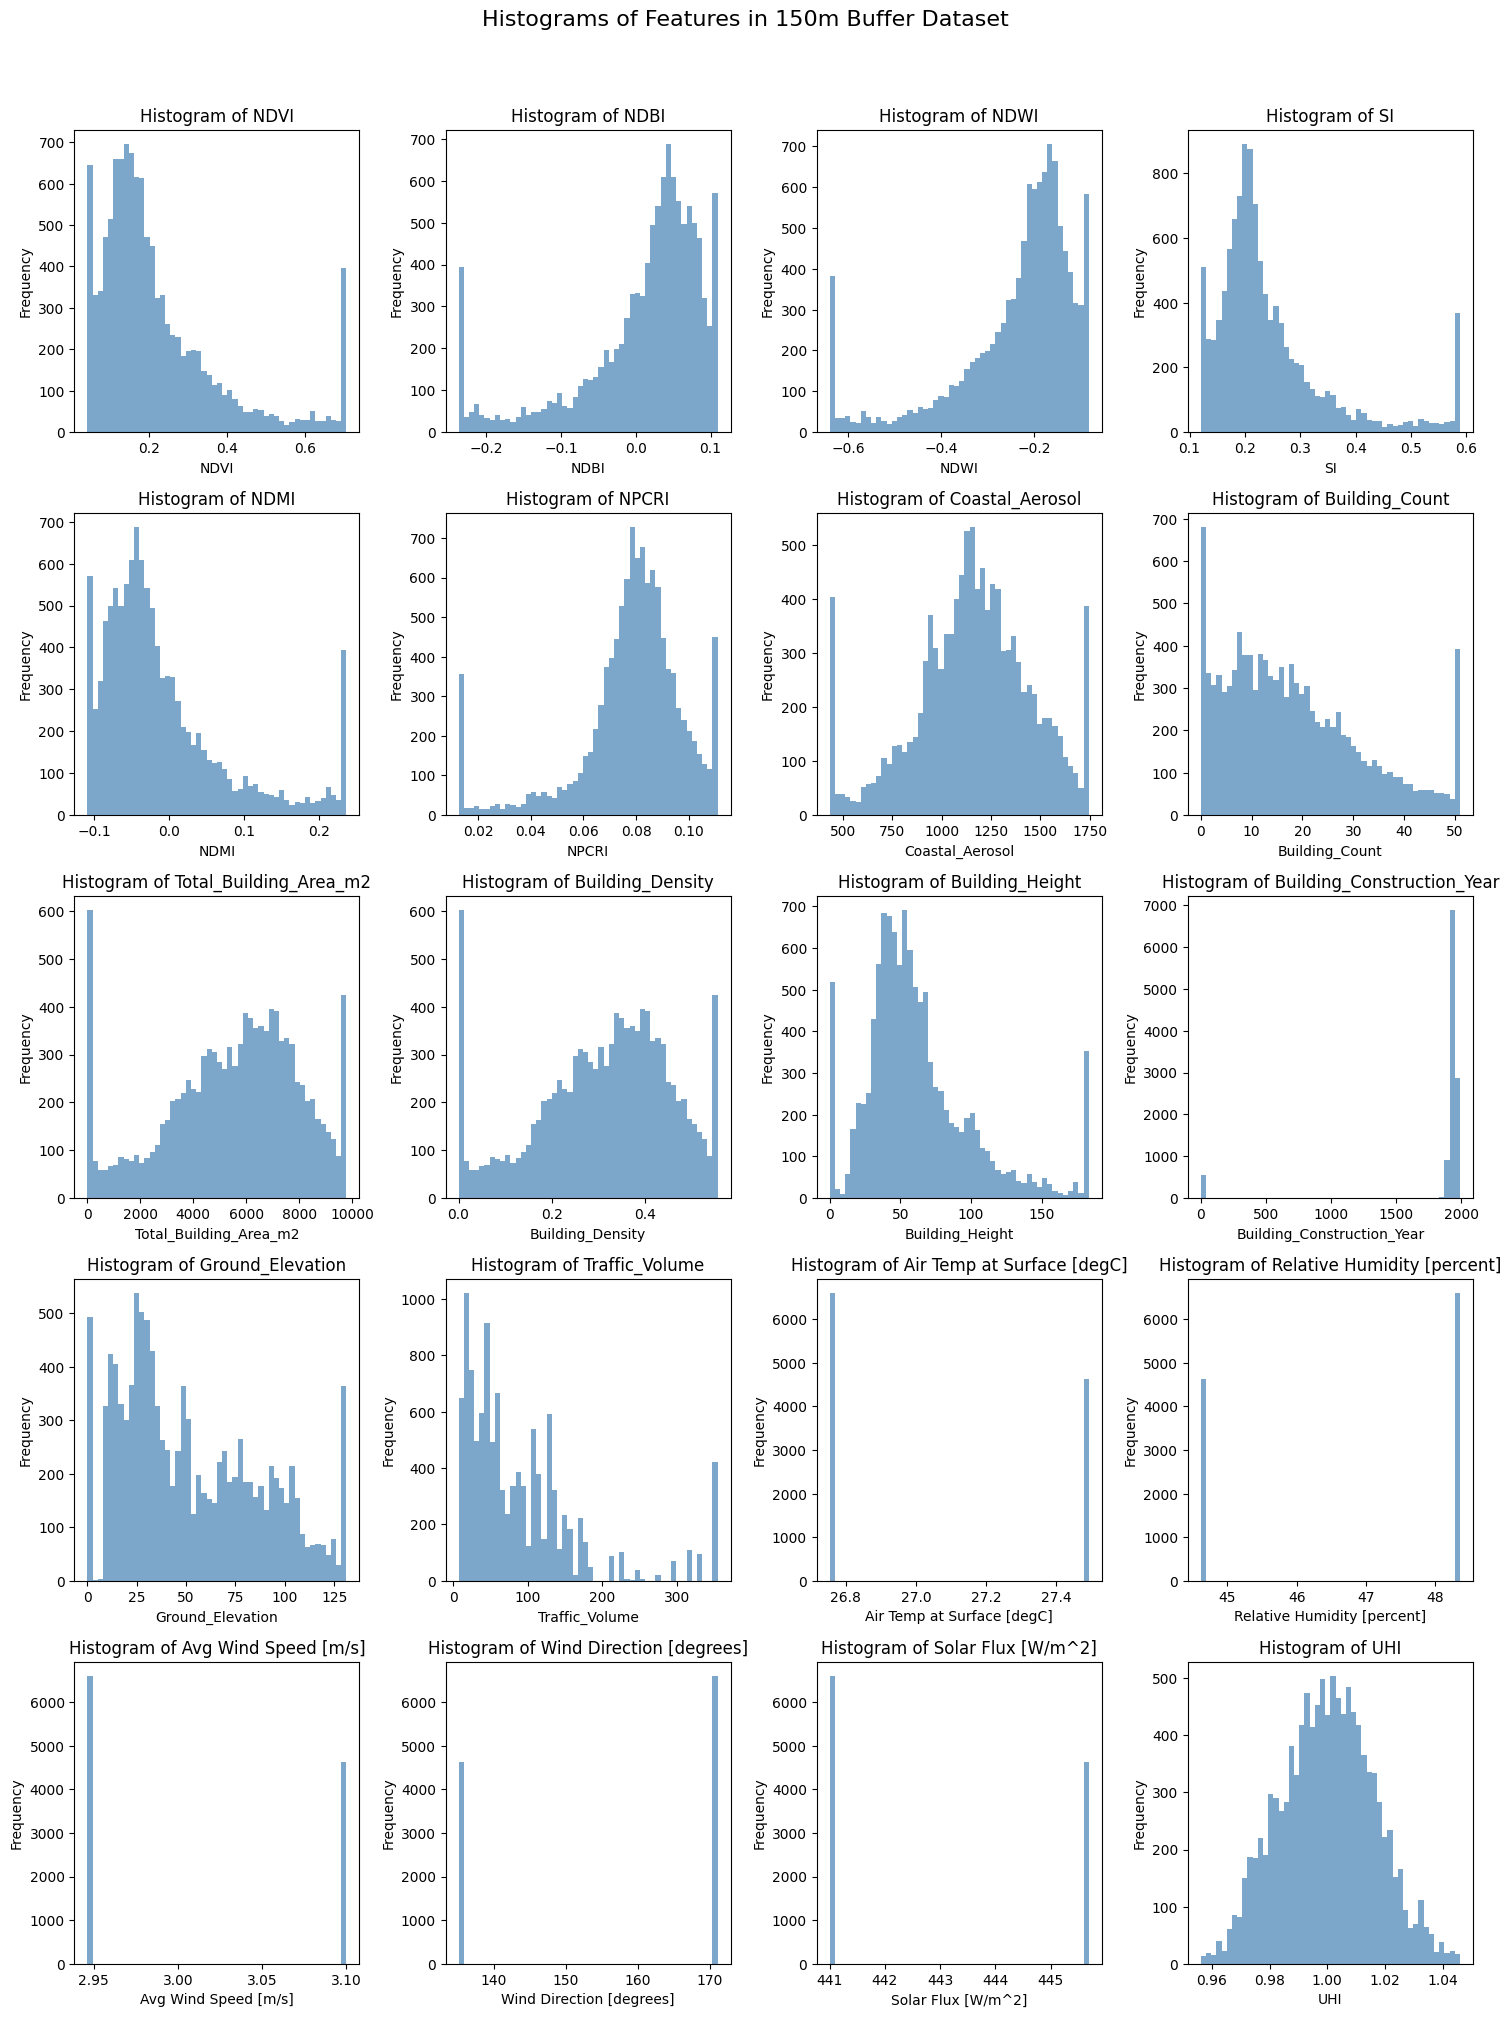

Skewness:
NDVI 1.5607059107394812
NDBI -1.4276861195444985
NDWI -1.5009704793919867
SI 1.7344832037948257
NDMI 1.4276861195444985
NPCRI -1.3107458996356212
Coastal_Aerosol -0.32656200536525254
Building_Count 0.7461893934223518
Total_Building_Area_m2 -0.47482685133077573
Building_Density -0.4748268513302392
Building_Height 1.2168055059904561
Building_Construction_Year -4.195830051926251
Ground_Elevation 0.5486151495275056
Traffic_Volume 1.7380061916817484
Air Temp at Surface [degC] 0.35696492405418956
Relative Humidity [percent] -0.3569649240542103
Avg Wind Speed [m/s] 0.3569649240541931
Wind Direction [degrees] -0.3569649240542005
Solar Flux [W/m^2] 0.35696492405417385
UHI 0.02547868830397157


In [75]:
plt = plot_all_histograms(dataset, "150m Buffer Dataset")
plt.show()
print("Skewness:")
for col in dataset.columns:
    print(col, skew(dataset[col]))

Here we can see what variables are skewed (ex; NDBI) and the skew score. To determine which features will receive the `boxcox` transformation we will use a skewness threshold.

In [76]:
SKEW_THRESHOLD=0.70

Apply the transformation.

In [79]:
dataset = apply_boxcox_transformation(dataset, SKEW_THRESHOLD)

Now, let's see the distributions again.

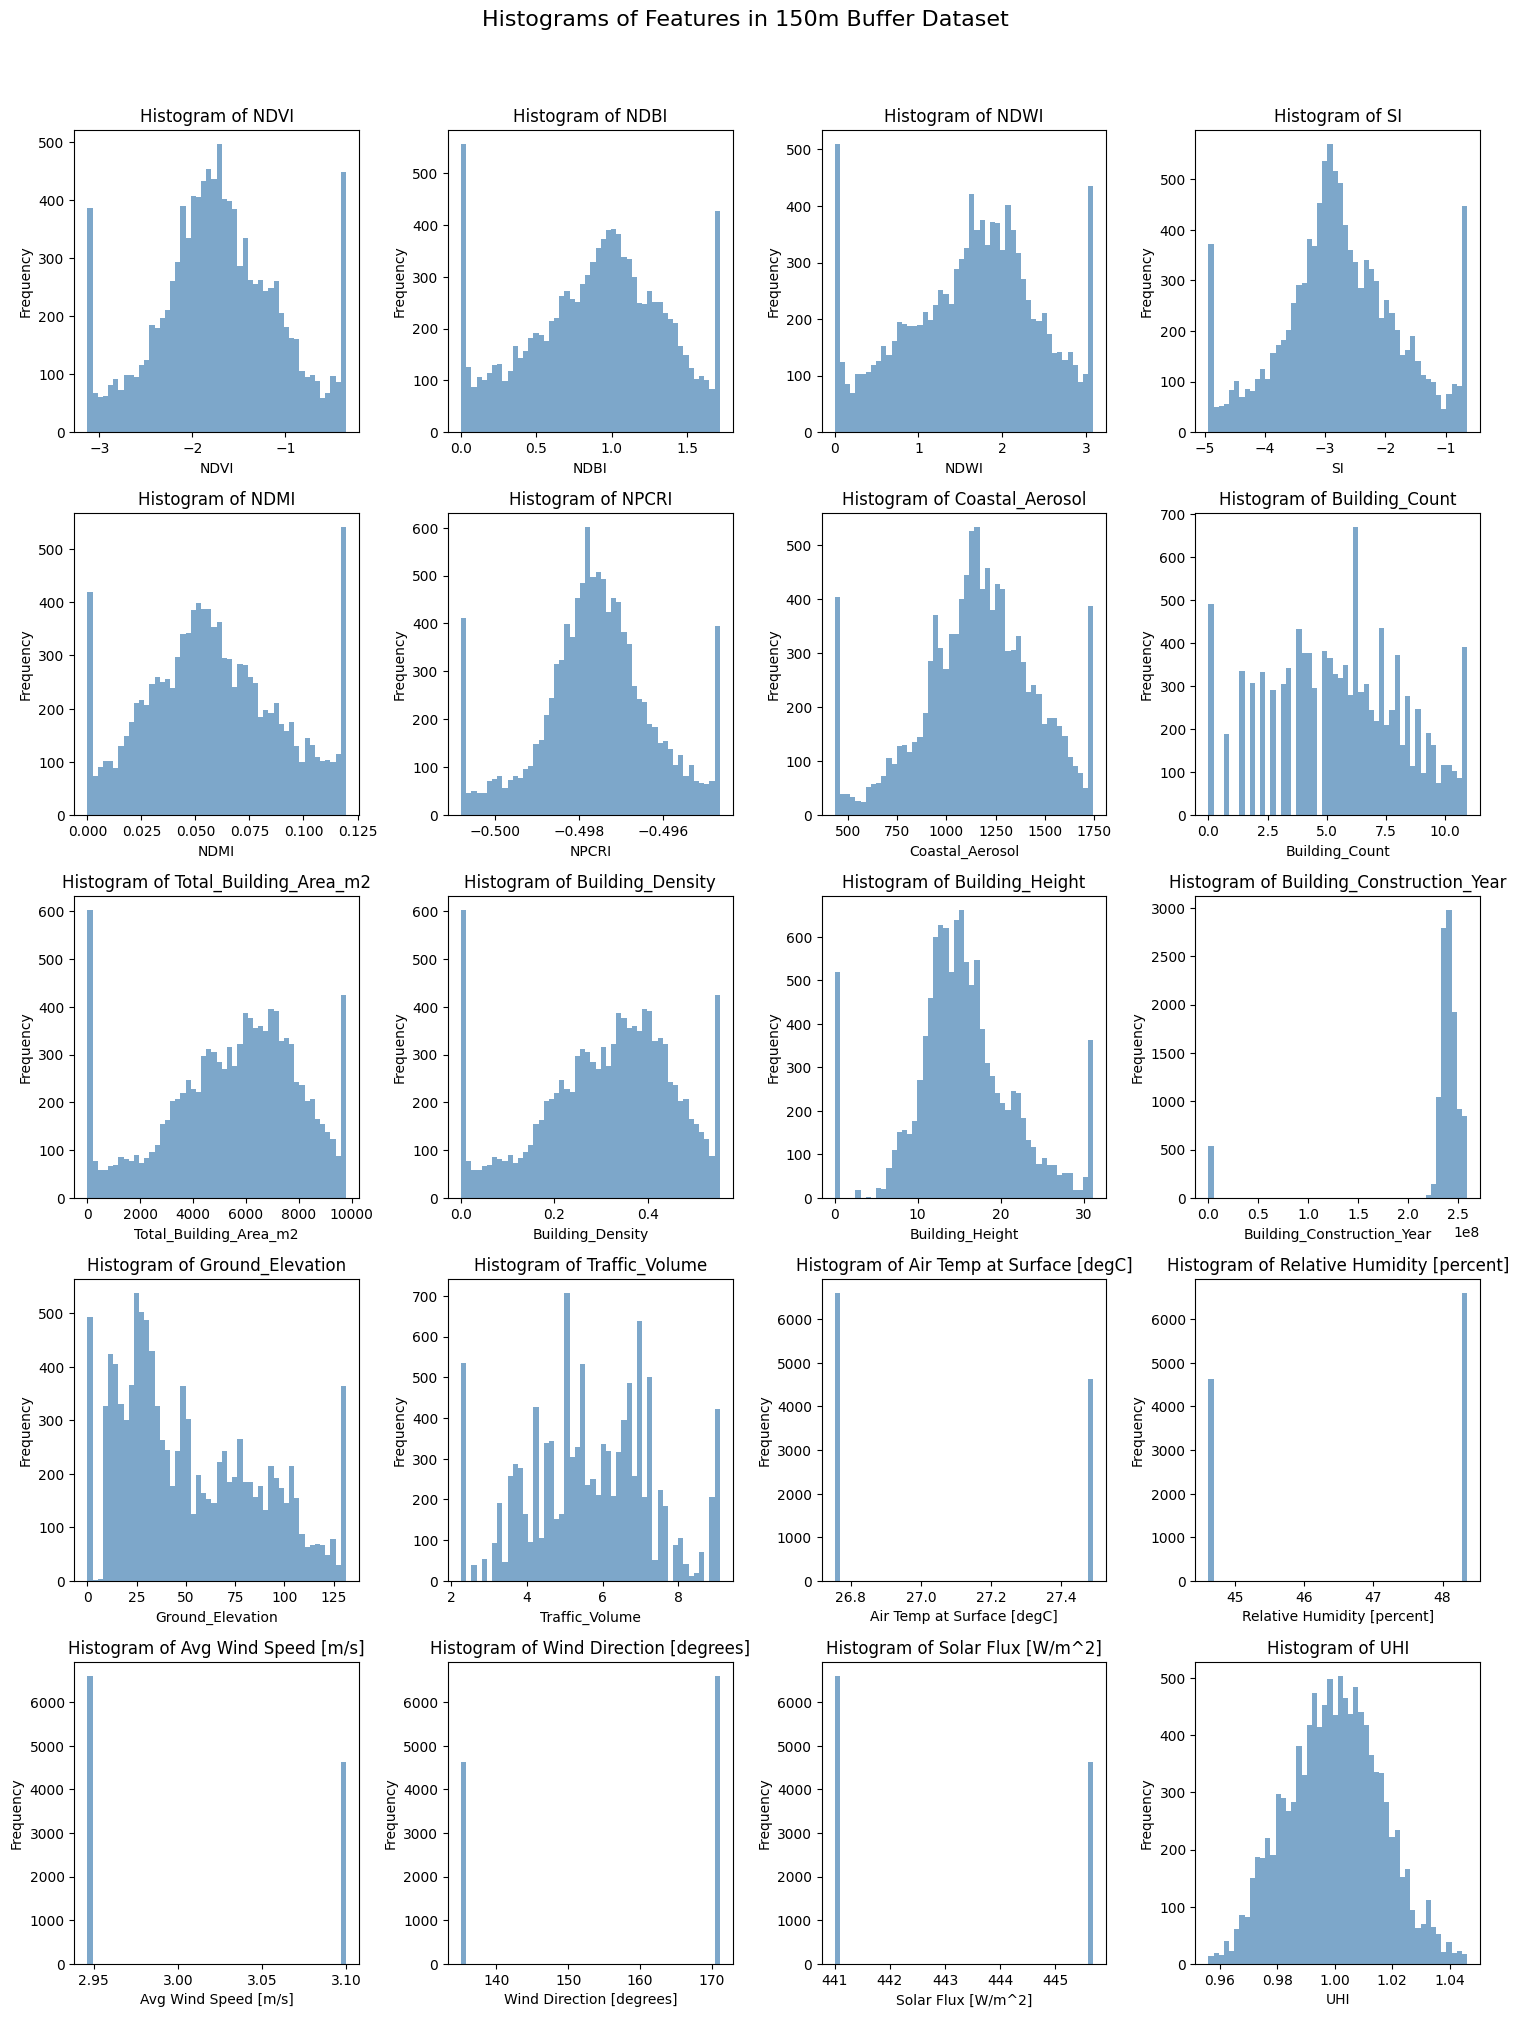

Skewness:
NDVI -0.0005829657420340314
NDBI -0.22708545838560346
NDWI -0.23901873081337924
SI 0.01814536399569054
NDMI 0.15298137622943372
NPCRI -0.15784719812800335
Coastal_Aerosol -0.32656200536525254
Building_Count -0.09586354505650399
Total_Building_Area_m2 -0.47482685133077573
Building_Density -0.4748268513302392
Building_Height 0.07471447745074554
Building_Construction_Year -4.076943931897217
Ground_Elevation 0.5486151495275056
Traffic_Volume -0.0180698687582296
Air Temp at Surface [degC] 0.35696492405418956
Relative Humidity [percent] -0.3569649240542103
Avg Wind Speed [m/s] 0.3569649240541931
Wind Direction [degrees] -0.3569649240542005
Solar Flux [W/m^2] 0.35696492405417385
UHI 0.02547868830397157


In [80]:
plt = plot_all_histograms(dataset, "150m Buffer Dataset")
plt.show()
print("Skewness:")
for col in dataset.columns:
    print(col, skew(dataset[col]))

We can see in the second graph that a lot of the features that were skewed are not skewed anymore.

# Conclusion

>TODO: Create the function that will apply everything in this notebook to the dataset that is passed through.

>TODO: copy all helper functions to tools.preprocess